In [1]:
!nvidia-smi

Mon Apr 23 01:08:11 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   31C    P8    15W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   31C    P8    15W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
from __future__ import print_function
#
import os
import glob
import re
import argparse
import pandas as pd
import numpy as np
import subprocess
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

from time import sleep
from tqdm import tqdm # if use notebook

from threading import Thread, Event
import queue

from PIL import Image
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

import random

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', default=5)
parser.add_argument('--image_dir', default="/home/seanyu/datasets/cat_dog/dataset/")
parser.add_argument('--save_dir', default='./result')
parser.add_argument('--is_training', default=1, type=int)
parser.add_argument('--batch_size', default=48, type=int)
parser.add_argument('--do_augment', default=True, type = bool)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--lr', default=0.0001, type=float)
parser.add_argument('--image_size', default=(150,150,3), type = int)
parser.add_argument('--n_classes', default=2, type = int)
parser.add_argument('--train_ratio', default=0.9, type = float)
parser.add_argument('--use_model_ckpt', default = None, type = str)
FLAGS = parser.parse_args([])
print(FLAGS)

Namespace(batch_size=48, do_augment=True, epochs=100, gpu_id=5, image_dir='/home/seanyu/datasets/cat_dog/dataset/', image_size=(150, 150, 3), is_training=1, lr=0.0001, n_classes=2, save_dir='./result', train_ratio=0.9, use_model_ckpt=None)


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)
import tensorflow as tf

if not os.path.exists(FLAGS.save_dir):
    os.makedirs(FLAGS.save_dir)

model_graph_name = FLAGS.save_dir + '/model'
    
graphs_dir = FLAGS.save_dir + '/graphs'
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

"""  Get data """
d_train = FLAGS.image_dir + '/train/'
d_test = FLAGS.image_dir + '/test1/'

image_train_list = glob.glob(d_train + '*.jpg')
image_test_list = glob.glob(d_test + '*.jpg')

df_train = pd.DataFrame({'img_path': image_train_list})
df_test = pd.DataFrame({'img_path': image_test_list})

df_train['cate'] = df_train.img_path.apply(os.path.basename)
df_train['cate'] = [i.split(".")[0] for i in list(df_train.cate)]
df_train.cate = df_train.cate.replace({'dog': 0, 'cat': 1})

nb_epoch = FLAGS.epochs

df_train_0, df_val_0 = train_test_split(df_train[df_train['cate'] == 0], test_size = 1-FLAGS.train_ratio)
df_train_1, df_val_1 = train_test_split(df_train[df_train['cate'] == 1], test_size = 1-FLAGS.train_ratio)

df_val = pd.concat((df_val_0, df_val_1)).reset_index(drop = True)

del df_val_0, df_val_1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def enqueue(queue, stop, gen_func):
    gen = gen_func()
    while True:
        if stop.is_set():
            return
        queue.put(next(gen))

class create_data_generator():
    def __init__(self,
                 df,
                 open_image_handler, 
                 data_frame_handler = None,
                 nd_inputs_preprocessing_handler = None,
                 batch_size = 32,
                 n_classes = 2,
                 aug_params = None):
        
        self.f_readImg = open_image_handler  # how to open image
        self.f_dataproc = data_frame_handler # how to proc original data
        self.f_inputs_preproc = nd_inputs_preprocessing_handler # how to do image preprocessing
        self.bz = batch_size
        self.n_classes = n_classes
        self.aug = aug_params
        
        # run functions at the begin
        # self.df should become list of dataframe anyway
        # if not, do the data_preproc. if yes, pass it
        if data_frame_handler:
            self.df = self.f_dataproc(df)
        else:
            self.df = df
       
    def get_train_data(self):
        while True:
            idxs = self.train_idx_queue.get()

            select_list = []

            for df, idx in zip(self.df, idxs):
                select_list.append(df.iloc[idx])
            select_list = pd.concat(select_list)
            
            x_ = np.array([self.f_readImg(iid) for iid in select_list.img_path], dtype=np.float32)
            x_ = x_.astype(np.float32)
            """ do preprocessing here"""
            if self.f_inputs_preproc:
                x_ = self.f_inputs_preproc(x_)
            else:
                pass

            """ Y out """
            y_ = np.array(select_list['cate'])
            y_ = tf.keras.utils.to_categorical(y_, self.n_classes)

            yield x_, y_
        
    def get_evaluate_data(self, target_df):
        
        x_ = np.array([cv_load_and_resize(i, is_training = False) for i in target_df.img_path], dtype=np.float32) # don't do augmentation!
    
        """ do preprocessing here"""
        if self.f_inputs_preproc:
            x_ = self.f_inputs_preproc(x_)
        else:
            pass
        
        """ Y out """
        y_ = np.array(target_df['cate'])
        y_ = tf.keras.utils.to_categorical(y_, num_classes=self.n_classes)
        
        return x_, y_
    
    def _get_train_idx(self):
        """ Description 
        Get training data index for each data frame in the data list
        # note1: self.df should be list of data frame with different categories
        # note2: if there is only 1 class (or for regression problem, should still be embraced [this_df] )
        """
        len_list = [len(df) for df in self.df]
        
        bz_t = self.bz//len(len_list)
        batch_num = [x//bz_t for x in len_list]

        batch_nth = [0] * len(len_list)

        select = [list(range(x)) for x in len_list]

        for s in select:
            random.shuffle(s)

        while True:
            idxs = []
            for i in range(len(len_list)):
                if batch_nth[i] >= batch_num[i]:
                    batch_nth[i] = 0
                    random.shuffle(select[i])
                idx = select[i][batch_nth[i]*bz_t:(batch_nth[i]+1)*bz_t]
                batch_nth[i] += 1
                idxs.append(idx)

            yield idxs
    

        
    def start_train_threads(self, jobs = 1):
        
        self.train_queue = queue.Queue(maxsize = 10)
        self.train_idx_queue =queue.Queue(maxsize = 100)
        
        ### for stop threads after training ###
        self.events=[]

        ### enqueue train index ###
        event = Event()
        thread = Thread(target = enqueue, 
                        args = (self.train_idx_queue, 
                                event, 
                                self._get_train_idx))
        thread.start()
        self.events.append(event)

        ### enqueue train batch ###
        for i in range(jobs):
            event = Event()
            thread = Thread(target = enqueue,args = (self.train_queue, 
                                                     event, 
                                                     self.get_train_data))
            thread.start()
            self.events.append(event)
        

In [5]:
class EarlyStopping():
    def __init__(self, patience, min_delta = 0.0001):
        # validation loss should at least be less than current min_loss - min_delta
        self.min_delta = min_delta 
        self.patience = patience
        self.epoch_count = 0
        self.min_loss = None
        self.stop = False
        
    def on_epoch_end(self, val_loss, *args, **kwargs):
        if self.min_loss is None or val_loss < self.min_loss - self.min_delta:
            self.min_loss = val_loss
            self.epoch_count = 0
        else:
            self.epoch_count += 1
            
        # if cumulative counts is larger than our patience, set the stop signal to True
        if self.epoch_count >= self.patience:
            self.stop = True
        
class Model_checkpoint():
    def __init__(self, model_name, save_best_only = True):
        self.min_loss = None
        self.model_name = model_name
        self.save_best_only = save_best_only
        
    def on_epoch_end(self, val_loss, nth_epoch, saver, sess, *args, **kwargs):
        if self.min_loss is None or val_loss < self.min_loss:
            self.min_loss = val_loss
            saver.save(sess, 
                       self.model_name + '.ckpt')
        if not self.save_best_only:
            saver.save(sess, 
                       self.model_name + '_' + str(nth_epoch) + '.ckpt',
                       global_step=nth_epoch)
        
class ReduceLROnPlateau():
    def __init__(self, lr, factor, patience, min_lr = 1e-10):
        self.lr = lr
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.min_loss = None
        self.epoch_count = 0
    
    def on_epoch_end(self, val_loss, *args, **kwargs):
        if self.min_loss is None or val_loss < self.min_loss:
            epoch_count = 0
            self.min_loss = val_loss
        else:
            self.epoch_count += 1
        
        if self.epoch_count == self.patience:
            self.lr *= self.factor
            self.epoch_count = 0
            
            if self.lr <= self.min_lr:
                self.lr = self.min_lr
                
class Run_collected_functions():
    def __init__(self, callback_dicts):
        self.on_session_begin = callback_dicts['on_session_begin']
        self.on_session_end = callback_dicts['on_session_end']
        self.on_batch_begin = callback_dicts['on_batch_begin']
        self.on_batch_end = callback_dicts['on_batch_end']
        self.on_epoch_begin = callback_dicts['on_epoch_begin']
        self.on_epoch_end = callback_dicts['on_epoch_end']
        
    def run_on_epoch_end(self, val_loss, nth_epoch = None, sess = None, saver = None):
        for func in self.on_epoch_end:
            getattr(func, 'on_epoch_end')(val_loss = val_loss,
                                          nth_epoch = nth_epoch,
                                          sess = sess,
                                          saver = saver)
        
    def run_on_session_end(self, *args, **kwargs):
        pass

In [6]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    sometimes(iaa.Affine(
            scale = (0.8,1.2),
            translate_percent = (-0.2, 0.2),
            rotate = (-30, 30),
            order = [0, 1],
            #cval = (0,255),
            mode = 'wrap'
            ))
])

def cv_load_and_resize(x, is_training = True):
    im_w, im_h, im_c = FLAGS.image_size
    im = cv2.imread(x)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (im_w, im_h))
    if FLAGS.do_augment and is_training:
        im = seq.augment_image(im)
    return im

In [7]:
data_gen = create_data_generator(df=[df_train_0, df_train_1],
                                 aug_params=seq,
                                 batch_size=FLAGS.batch_size, 
                                 open_image_handler=cv_load_and_resize)
data_gen.start_train_threads(6)

In [8]:
x_val, y_val = data_gen.get_evaluate_data(df_val)
print(x_val.shape)

(2500, 150, 150, 3)


In [9]:
tf.reset_default_graph()
im_w, im_h, im_c = FLAGS.image_size
drp_holder = tf.placeholder(tf.float32)

a_in = tf.keras.layers.Input(shape = (im_w, im_h, im_c))
x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, activation=tf.nn.selu)(a_in)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, activation=tf.nn.selu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, activation=tf.nn.selu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(units=64, activation=tf.nn.selu)(x)
x = tf.keras.layers.Dropout(drp_holder)(x)

x = tf.keras.layers.Dense(units=32, activation=tf.nn.selu)(x)
x = tf.keras.layers.Dropout(drp_holder)(x)

out = tf.keras.layers.Dense(units=FLAGS.n_classes, activation='linear')(x) # softmax will be at loss part
prediction = tf.nn.softmax(out)

y_holder = tf.placeholder(tf.float32, shape=[None, FLAGS.n_classes])
total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_holder, logits=out))


optim = tf.train.AdamOptimizer(learning_rate=FLAGS.lr)
optim_op = optim.minimize(total_loss)

correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), 
                              tf.argmax(y_holder, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
n_batch = len(df_train) // FLAGS.batch_size + 1 # standard way - look all samples per epoch

early_stop = EarlyStopping(patience=10)
model_checkpt = Model_checkpoint(model_name=model_graph_name, save_best_only=True)
reduce_lr = ReduceLROnPlateau(lr=FLAGS.lr, factor=0.5, patience=3)

callback_dict = {
    'on_session_begin':[], # start of a session
    'on_batch_begin':[], # start of a training batch
    'on_batch_end':[], # end of a training batch
    'on_epoch_begin':[], # start of a epoch
    'on_epoch_end':[early_stop, reduce_lr, model_checkpt], # end of a epoch
    'on_session_end':[] # end of a session
    }
callback_manager = Run_collected_functions(callback_dict)


# -------------------------- #
global_train_loss, global_train_acc = [], []
global_valid_loss, global_valid_acc = [], []

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run([tf.global_variables_initializer()])
    
    """
    epoch_bar = tqdm(range(FLAGS.epochs), 
                     desc = "Train epoch", 
                     unit = "Epoch")
    """
    epoch_bar = range(FLAGS.epochs)
    for i in epoch_bar:
        """
        if i == 0:
            epoch_bar.set_description("Training loss/acc: %.2f/%.2f ;Validation: %.2f/%.2f" % 
                                  (0.0,0.0,0.0,0.0))
        else:
            epoch_bar.set_description("Training loss/acc: %.2f/%.2f ;Validation: %.2f/%.2f" % 
                                  (global_train_loss[-1], global_train_acc[-1], global_valid_loss[-1], global_valid_acc[-1]))
        """
        train_epoch_loss, train_epoch_acc = [], []
        train_batch_bar = tqdm(range(n_batch), 
                               desc = "Training batch", 
                               unit = "batch", 
                               leave = True)
        for j in train_batch_bar:
            x_, y_ = data_gen.train_queue.get()
            
            batch_loss, batch_acc, _ = sess.run([total_loss, accuracy_op, optim_op], 
                                                feed_dict = {a_in: x_, 
                                                                     y_holder: y_, 
                                                                     tf.keras.backend.learning_phase(): 1,
                                                                     drp_holder: 0.2})
            train_epoch_loss.append(batch_loss)
            train_epoch_acc.append(batch_acc)
            current_train_loss = np.mean(train_epoch_loss)
            current_train_acc = np.mean(train_epoch_acc)
            train_batch_bar.set_description('Epoch: %i, Training loss/acc: %.2f/%.2f' % (int(i+1),current_train_loss, current_train_acc))
            
        
        global_train_loss.append(current_train_loss)
        global_train_acc.append(current_train_acc)
        
        valid_epoch_loss, valid_epoch_acc = [], []
        
        valid_step = range(len(df_val) // FLAGS.batch_size + 1)
        valid_batch_bar = tqdm(valid_step, 
                               desc = "Valid batch", 
                               unit = "batch", leave = True)
        
        #valid_batch_bar = range(len(df_val) // FLAGS.batch_size + 1)
        for j in valid_batch_bar:
            this_val_loss, this_val_acc = sess.run([total_loss, accuracy_op], 
                                                       feed_dict = {a_in: x_val[j*FLAGS.batch_size : (j+1) * FLAGS.batch_size], 
                                                                            y_holder: y_val[j*FLAGS.batch_size : (j+1) * FLAGS.batch_size],
                                                                            tf.keras.backend.learning_phase(): 0,
                                                                            drp_holder: 0.0} )
            valid_epoch_loss.append(this_val_loss)
            valid_epoch_acc.append(this_val_acc)
            
            if j == np.max(valid_step):
                current_valid_loss = np.mean(valid_epoch_loss)
                current_valid_acc = np.mean(valid_epoch_acc)
                valid_batch_bar.set_description('Epoch: %i, Validation loss/acc: %.2f/%.2f' % (int(i+1), current_valid_loss, current_valid_acc))

        # 
        global_valid_loss.append(current_valid_loss)
        global_valid_acc.append(current_valid_acc)
        
        #
        callback_manager.run_on_epoch_end(val_loss = current_valid_loss,
                                          sess = sess,
                                          saver = saver,
                                          nth_epoch = i)
        if early_stop.stop:
            print("EarlyStop!")
            break

Epoch: 34, Training loss/acc: 0.46/0.79:  56%|█████▌    | 290/521 [00:13<00:11, 20.73batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 45, Training loss/acc: 0.42/0.81:  60%|██████    | 314/521 [00:15<00:10, 20.66batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 59, Training loss/acc: 0.38/0.83:  54%|█████▍    | 283/521 [00:13<00:11, 20.65batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop 

Epoch: 67, Training loss/acc: 0.40/0.82:   5%|▌         | 28/521 [00:00<00:15, 32.30batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 70, Training loss/acc: 0.37/0.85:  43%|████▎     | 225/521 [00:10<00:14, 20.93batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 78, Validation loss/acc: 0.33/0.85: 100%|██████████| 53/53 [00:00<00:00, 83.84batch/s]


EarlyStop!


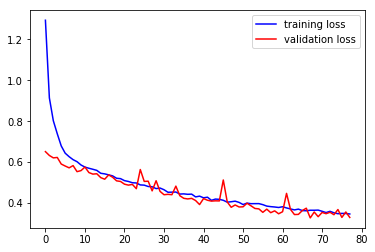

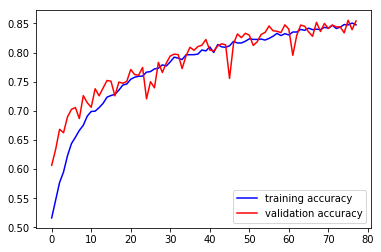

In [14]:
plt.plot(range(len(global_train_loss)), global_train_loss, 'b', label = 'training loss')
plt.plot(range(len(global_valid_loss)), global_valid_loss, 'r', label = 'validation loss')
plt.legend()
plt.show()

plt.plot(range(len(global_train_acc)), global_train_acc, 'b', label = 'training accuracy')
plt.plot(range(len(global_valid_acc)), global_valid_acc, 'r', label = 'validation accuracy')
plt.legend(loc = 4)
plt.show()

In [15]:
# restore and prediction
n_pickup = 100
pred_id = np.random.choice(np.arange(len(x_val)), replace=False, size=n_pickup)
with tf.Session() as sess:
    saver.restore(sess, model_graph_name + ".ckpt")
    print("Run predict on Test mode")
    pred_res = sess.run(prediction, 
                        feed_dict = {a_in: x_val[pred_id], 
                                     tf.keras.backend.learning_phase(): 0,
                                     drp_holder: 0.0} )
# Accuracy
np.sum(pred_res.argmax(axis = 1) == y_val[pred_id].argmax(axis = 1)) / len(pred_id)

INFO:tensorflow:Restoring parameters from ./result/model.ckpt
Run predict on Test mode


0.87

In [16]:
experiment_images_list = glob.glob("./Experiment_images/*.jpg")
experiment_images_list = pd.DataFrame({'img_path':experiment_images_list, 'cate':1})
x_exp, y_exp = data_gen.get_evaluate_data(experiment_images_list)
print(x_exp.shape)
experiment_images_list.img_path

(6, 150, 150, 3)


0    ./Experiment_images/cat_original_position_shif...
1    ./Experiment_images/cat_original_sharpend_main...
2                 ./Experiment_images/cat_original.jpg
3    ./Experiment_images/cat_original_sharpen_once.jpg
4    ./Experiment_images/cat_original_position_shif...
5    ./Experiment_images/cat_original_blur_surround...
Name: img_path, dtype: object

In [17]:
with tf.Session() as sess:
    saver.restore(sess, model_graph_name + ".ckpt")
    print("Run predict on Test mode")
    pred_res = sess.run(prediction, 
                        feed_dict = {a_in: x_exp, 
                                     tf.keras.backend.learning_phase(): 0,
                                     drp_holder: 0.0} )

INFO:tensorflow:Restoring parameters from ./result/model.ckpt
Run predict on Test mode


In [19]:
print(pred_res)
print(pred_res.argmax(axis = 1))

[[0.7037724  0.29622754]
 [0.12173333 0.8782667 ]
 [0.38463148 0.61536855]
 [0.54993397 0.450066  ]
 [0.4446047  0.5553953 ]
 [0.11018401 0.88981605]]
[0 1 1 0 1 1]


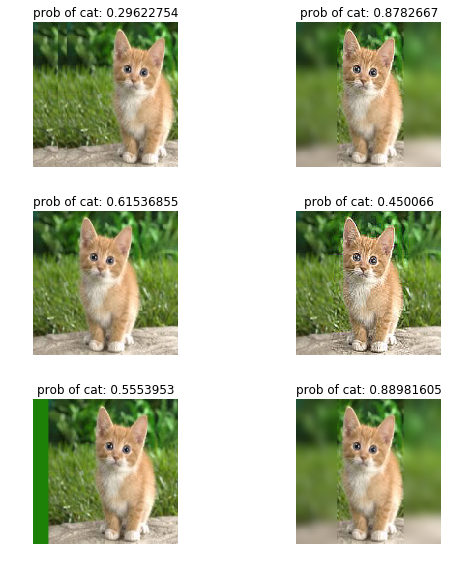

In [32]:
fig = plt.figure(figsize=(8,8))
rows = 3
cols = len(experiment_images_list) // rows

for i in range(1, len(experiment_images_list) + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(x_exp[i-1].astype('uint8'))
    plt.title('prob of cat: ' + str(pred_res[i-1][1]) )
    plt.axis('off')
plt.tight_layout()
plt.show()